# Predicting product cancelations for sales retention
Investigate machine learning techniques to predict the likely-hood of a product cancellation based on existing sales and amount spent in annual maintenance. To enable the targeting of retention resources and offers to those customers who are predicted as at risk. 

In [1]:
# get updated version on pandas
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
if LooseVersion(pd.__version__) < LooseVersion("0.22.0"):
    !pip install --upgrade pandas
    pd.__version__
    print("pandas version was: " + pd.__version__ + " It has been updated, please restart the kernel")
else:
    print("pandas version is high enough")

pandas version is high enough


In [2]:
#some extra libs that we need in the page:
#!pip install hypopt
#!pip install --upgrade seaborn
!pip install pdtransform
!pip install tabulate
!pip install seaborn==0.9.0 

In [3]:
# setup the notebook and import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    accuracy_score
    )
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, classification_report,make_scorer
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
#from sklearn import cross_validation
from pdtransform import DFTransform, DFFeatureUnion
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
%matplotlib inline

#Get the data from the same folder as the notebook and test the pandas version
csvData = './ResultsGrid.csv'
isCancelledKey = 'isCancelled'
customerIdKey = 'customerId'
adminAreaKey = 'administrativeArea'
subCountryKey = 'subCountryArea'
countryKey = 'country'
avgDaysToPay='avgDaysToPay'

In [33]:
#seaborn defaults - see http://www.jesshamrick.com/2016/04/13/reproducible-plots/
sns.set_context("paper") 
# Set the font to be serif, rather than sans
sns.set(font='serif')
# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
# configure seaborn https://seaborn.pydata.org/
sns.set(color_codes=True)
colors = ["amber", "windows blue", "red","green", "grey", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

# The machine learning pipeline
![](https://cdn-images-1.medium.com/max/1600/1*2T5rbjOBGVFdSvtlhCqlNg.png)

In [5]:
pd.set_option('display.max_rows', 100)
dataFrame = pd.read_csv(csvData)
isCancelledIndex = dataFrame.columns.get_loc(isCancelledKey)
dataFrame.head()

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
0,215093,159.2,159.2,0.0,0.0,0.0,0.0,1,-1,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,01/06/2018
1,215092,239.0,239.0,0.0,0.0,0.0,0.0,2,10,0.0,...,False,False,False,False,False,True,none,none,United Kingdom,25/05/2018
2,215091,239.0,239.0,0.0,0.0,0.0,0.0,2,33,0.0,...,False,False,False,False,False,True,WORCESTERSHIRE,West Midlands,United Kingdom,25/05/2018
3,215090,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018
4,215089,125.0,125.0,0.0,0.0,0.0,0.0,2,35,0.0,...,False,False,False,False,False,True,BEXLEY,London,United Kingdom,24/05/2018


In [6]:
dataFrame = dataFrame.infer_objects()
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676 entries, 0 to 4675
Data columns (total 27 columns):
customerId              4676 non-null int64
amountTotal             4676 non-null float64
salesTotal              4676 non-null float64
annualTotal             4676 non-null float64
monthlyTotalProduct1    4676 non-null float64
monthlyTotalProduct2    4676 non-null float64
extraItemsTotal         4676 non-null float64
monthsSinceStarted      4676 non-null int64
avgDaysToPay            4676 non-null int64
creditedAmount          4676 non-null float64
isCancelled             4676 non-null bool
hasProduct1             4676 non-null bool
hasProduct2             4676 non-null bool
hasProduct3             4676 non-null bool
hasProduct4             4676 non-null bool
hasProduct5             4676 non-null bool
hasProduct6             4676 non-null bool
hasProduct7             4676 non-null bool
hasProduct8             4676 non-null bool
hasProduct9             4676 non-null bool
hasProduc

In [7]:
dataFrame.describe(include='all')

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676,4676,4676,4676,4676,4676,4676,4676,4676,4676
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,2,2,2,2,217,15,11,1400
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,none,North West,United Kingdom,30/11/2009
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4663,4646,4675,3991,4616,3293,244,1040,4550,82
mean,46900.834474,8199.874506,1091.890119,2638.875297,1719.273641,2563.909930,185.912380,62.047049,55.949102,201.173556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,67281.977821,13508.391594,2142.141606,4175.236029,4170.699589,6703.879866,941.121206,46.325072,184.911668,1290.280499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-10162.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3808.750000,657.000000,149.000000,240.000000,0.000000,0.000000,0.000000,22.000000,23.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,11919.500000,2650.000000,310.000000,1000.000000,0.000000,121.415000,0.000000,54.000000,41.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,38661.000000,9256.892500,897.000000,3150.000000,964.875000,2123.912500,0.000000,96.000000,67.250000,1.850000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Describe the boolean cols, including the dependant `isCancelled` col
#dataFrame.describe(include=['bool'])
booltypes = dataFrame.select_dtypes(include=['bool'])
booltypes.apply(pd.Series.value_counts)

,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
False,2600,2798,1802,4676.0,4372,4675,4676.0,4663,4646,4675,3991,4616,3293
True,2076,1878,2874,NaN,304,1,NaN,13,30,1,685,60,1383


In [9]:
# from https://stackoverflow.com/a/44702024
nans = lambda df: df[df.isnull().any(axis=1)]
nans(dataFrame)

# Remove if found above - none found...
# drop the rows where values are nan and return the new dataframe
# dataFrame = dataFrame.dropna(axis=0)

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate


In [10]:
# Find correlations and sort
# dataFrame.corr()[isCancelledKey].sort_values()
corr_matrix = dataFrame.corr()
corr_matrix[isCancelledKey].sort_values(ascending=False)

isCancelled             1.000000
hasProduct2             0.247663
hasProduct1             0.189850
hasProduct4             0.087349
creditedAmount          0.064485
salesTotal              0.030795
hasProduct7             0.026391
avgDaysToPay            0.021927
monthlyTotalProduct1    0.016987
hasProduct5            -0.013069
hasProduct9            -0.013069
annualTotal            -0.022727
hasProduct8            -0.034066
amountTotal            -0.064680
hasProduct11           -0.067456
monthsSinceStarted     -0.068659
monthlyTotalProduct2   -0.117760
extraItemsTotal        -0.134093
customerId             -0.163728
hasProduct10           -0.310549
hasProduct12           -0.369712
hasProduct3                  NaN
hasProduct6                  NaN
Name: isCancelled, dtype: float64

# Heatmap of correlations

In [11]:
corrDf = dataFrame.drop(['firstInvoiceDate',customerIdKey,adminAreaKey,subCountryKey,countryKey], axis=1)
corr = corrDf.corr()
corrDf.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\nathan\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.58,0.78,0.8,0.82,0.18,0.63,-0.087,0.11,-0.065,0.49,0.2,nan,0.19,-0.0035,nan,0.012,0.15,-0.0078,0.027,-0.036,-0.23
salesTotal,0.58,1.0,0.56,0.36,0.26,0.12,0.27,-0.064,0.17,0.031,0.34,0.1,nan,0.089,-0.0075,nan,0.0058,0.4,-0.0048,-0.0059,-0.028,-0.15
annualTotal,0.78,0.56,1.0,0.58,0.4,0.11,0.62,-0.083,0.16,-0.023,0.46,0.16,nan,0.17,0.0081,nan,0.012,0.38,-0.0072,-0.011,-0.042,-0.24
monthlyTotalProduct1,0.8,0.36,0.58,1.0,0.5,0.055,0.57,-0.089,0.055,0.017,0.5,0.16,nan,0.2,-0.0059,nan,-0.014,-0.033,-0.006,-0.022,-0.038,-0.21
monthlyTotalProduct2,0.82,0.26,0.4,0.5,1.0,0.079,0.42,-0.046,0.021,-0.12,0.27,0.15,nan,0.11,-0.0056,nan,0.016,-0.031,-0.0056,0.071,-0.014,-0.13
extraItemsTotal,0.18,0.12,0.11,0.055,0.079,1.0,0.14,-0.012,0.048,-0.13,0.067,0.11,nan,0.029,-0.0029,nan,0.058,-0.016,-0.0023,0.049,-0.0056,-0.024
monthsSinceStarted,0.63,0.27,0.62,0.57,0.42,0.14,1.0,-0.081,0.064,-0.069,0.43,0.44,nan,0.17,0.028,nan,-0.021,-0.036,0.035,-0.039,-0.05,-0.33
avgDaysToPay,-0.087,-0.064,-0.083,-0.089,-0.046,-0.012,-0.081,1.0,0.052,0.022,-0.12,-0.044,nan,-0.045,-0.003,nan,-0.0099,0.013,0.0048,-0.014,0.004,0.078
creditedAmount,0.11,0.17,0.16,0.055,0.021,0.048,0.064,0.052,1.0,0.064,0.049,0.037,nan,0.021,-0.0023,nan,0.0068,0.21,0.0034,-0.021,-0.013,-0.051
isCancelled,-0.065,0.031,-0.023,0.017,-0.12,-0.13,-0.069,0.022,0.064,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


In [12]:
corrDf.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\nathan\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,isCancelled,hasProduct1,hasProduct2,hasProduct3,hasProduct4,hasProduct5,hasProduct6,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12
amountTotal,1.0,0.49,0.9,0.7,0.69,0.17,0.8,-0.18,0.24,0.033,0.58,0.43,nan,0.16,0.0064,nan,0.003,0.1,-0.0088,-0.002,-0.039,-0.38
salesTotal,0.49,1.0,0.36,0.34,0.3,0.16,0.23,0.013,0.16,-0.12,0.25,0.11,nan,0.085,-0.02,nan,-0.031,0.13,0.0028,0.081,0.011,0.057
annualTotal,0.9,0.36,1.0,0.65,0.55,0.13,0.8,-0.19,0.26,0.098,0.55,0.39,nan,0.19,0.016,nan,0.026,0.089,-0.0063,-0.05,-0.052,-0.38
monthlyTotalProduct1,0.7,0.34,0.65,1.0,0.36,-0.021,0.56,-0.37,0.13,0.13,0.83,0.25,nan,0.27,0.0092,nan,0.0017,-0.055,0.0085,-0.033,-0.053,-0.34
monthlyTotalProduct2,0.69,0.3,0.55,0.36,1.0,0.18,0.66,0.037,0.19,-0.14,0.22,0.48,nan,0.055,-0.015,nan,-0.023,-0.085,-0.015,0.15,0.011,-0.26
extraItemsTotal,0.17,0.16,0.13,-0.021,0.18,1.0,0.17,0.099,0.2,-0.17,-0.0012,0.19,nan,-0.014,-0.005,nan,0.022,-0.02,0.037,0.096,0.015,-0.047
monthsSinceStarted,0.8,0.23,0.8,0.56,0.66,0.17,1.0,-0.039,0.24,-0.019,0.41,0.5,nan,0.15,0.023,nan,-0.024,-0.033,0.024,-0.061,-0.055,-0.36
avgDaysToPay,-0.18,0.013,-0.19,-0.37,0.037,0.099,-0.039,1.0,0.17,-0.097,-0.39,-0.0075,nan,-0.15,-0.015,nan,-0.043,0.056,0.019,0.03,0.026,0.17
creditedAmount,0.24,0.16,0.26,0.13,0.19,0.2,0.24,0.17,1.0,0.12,0.087,0.21,nan,0.048,-0.0085,nan,0.0093,0.028,0.027,-0.0014,-0.01,-0.12
isCancelled,0.033,-0.12,0.098,0.13,-0.14,-0.17,-0.019,-0.097,0.12,1.0,0.19,0.25,nan,0.087,-0.013,nan,0.026,-0.034,-0.013,-0.31,-0.067,-0.37


# Feature investigation

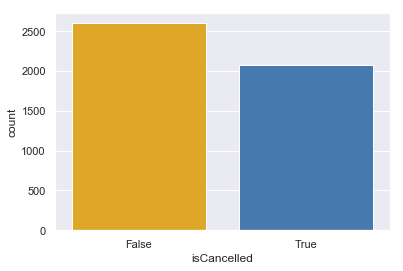

In [13]:
bar = sns.countplot(x=isCancelledKey,data=dataFrame)
fig = bar.get_figure()
fig.savefig('dependantSpread.eps', format='eps')

In [16]:
categoryFeatures = [subCountryKey] #[adminAreaKey, subCountryKey,countryKey]
oneHotDataFrame = pd.get_dummies(dataFrame,columns=categoryFeatures, dummy_na=True)
oneHotDataFrame.describe()

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,subCountryArea_North West,subCountryArea_Northern Ireland,subCountryArea_Scotland,subCountryArea_South East,subCountryArea_South West,subCountryArea_Wales,subCountryArea_West Midlands,subCountryArea_Yorkshire and the Humber,subCountryArea_none,subCountryArea_nan
count,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,...,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.000000,4676.0
mean,46900.834474,8199.874506,1091.890119,2638.875297,1719.273641,2563.909930,185.912380,62.047049,55.949102,201.173556,...,0.222412,0.028657,0.048760,0.113345,0.076775,0.048760,0.093028,0.036356,0.053251,0.0
std,67281.977821,13508.391594,2142.141606,4175.236029,4170.699589,6703.879866,941.121206,46.325072,184.911668,1290.280499,...,0.415911,0.166858,0.215388,0.317048,0.266263,0.215388,0.290503,0.187194,0.224557,0.0
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-10162.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,3808.750000,657.000000,149.000000,240.000000,0.000000,0.000000,0.000000,22.000000,23.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,11919.500000,2650.000000,310.000000,1000.000000,0.000000,121.415000,0.000000,54.000000,41.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,38661.000000,9256.892500,897.000000,3150.000000,964.875000,2123.912500,0.000000,96.000000,67.250000,1.850000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,215093.000000,227470.154000,35128.470000,79443.780000,39997.720000,169304.310000,19850.000000,197.000000,1258.000000,64171.440000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


# Skew data

In [17]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
matplotlib.style.use('ggplot')

skewColumns = dataFrame.skew(numeric_only="true")
skewRightColumns = skewColumns[lambda x : (x > 0.25)]
skewLeftColumns = skewColumns[lambda x : (x < -0.25)]
print(f"Skew right columns: {skewRightColumns}")
print("")
print(f"Skew left columns: {skewLeftColumns}")

Skew right columns: customerId               1.590838
amountTotal              3.609492
salesTotal               4.317364
annualTotal              4.863567
monthlyTotalProduct1     3.685016
monthlyTotalProduct2     7.965091
extraItemsTotal          9.006699
monthsSinceStarted       0.687165
creditedAmount          31.048405
hasProduct1              0.401472
hasProduct4              3.529746
hasProduct5             68.381284
hasProduct7             18.892434
hasProduct8             12.368155
hasProduct9             68.381284
hasProduct10             2.000120
hasProduct11             8.659933
hasProduct12             0.895294
dtype: float64

Skew left columns: avgDaysToPay   -36.079186
hasProduct2     -0.471209
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013179F836D8>,
      dtype=object)

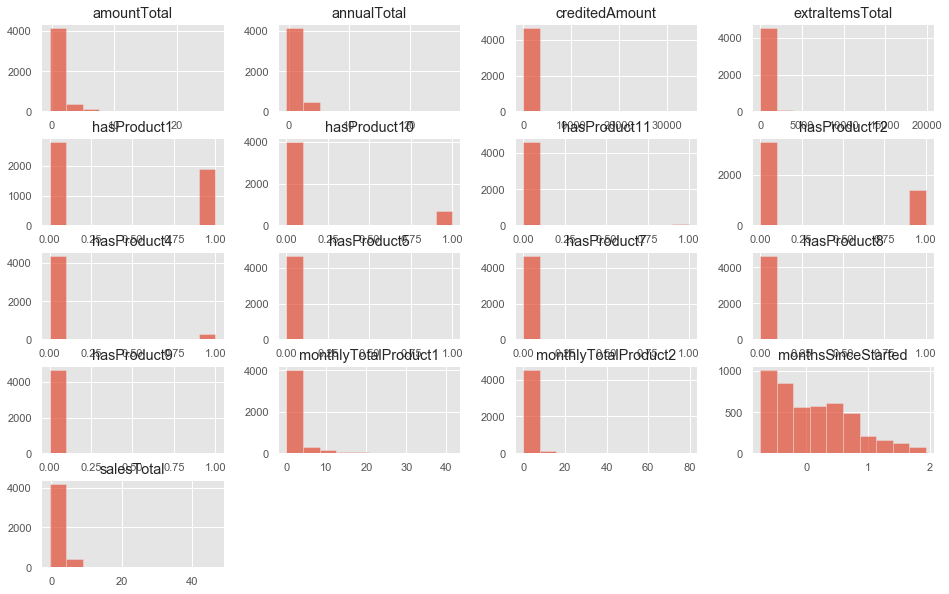

In [18]:
#Get the skewed cols
scaler = RobustScaler()
skewRightDf = dataFrame[skewRightColumns.index]
skewRightDf = skewRightDf.drop([customerIdKey], axis=1)
skewRightDf[skewRightDf.columns] = scaler.fit_transform(skewRightDf[skewRightDf.columns])
skewRightDf.hist(alpha=0.7, figsize=(16, 10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4676 entries, 0 to 4675
Data columns (total 18 columns):
customerId              4676 non-null int64
amountTotal             4676 non-null float64
salesTotal              4676 non-null float64
annualTotal             4676 non-null float64
monthlyTotalProduct1    4676 non-null float64
monthlyTotalProduct2    4676 non-null float64
extraItemsTotal         4676 non-null float64
monthsSinceStarted      4676 non-null int64
creditedAmount          4676 non-null float64
hasProduct1             4676 non-null bool
hasProduct4             4676 non-null bool
hasProduct5             4676 non-null bool
hasProduct7             4676 non-null bool
hasProduct8             4676 non-null bool
hasProduct9             4676 non-null bool
hasProduct10            4676 non-null bool
hasProduct11            4676 non-null bool
hasProduct12            4676 non-null bool
dtypes: bool(9), float64(7), int64(2)
memory usage: 370.0 KB
None


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001317B236C50>,
      dtype=object)

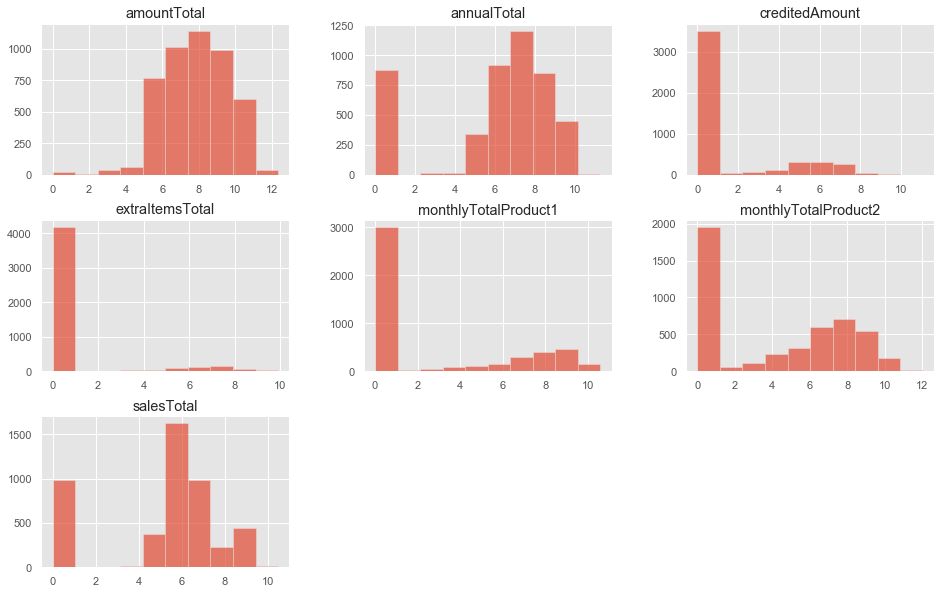

In [20]:
#Log transform
skewRightDf = dataFrame[skewRightColumns.index]
skewRightDf = skewRightDf.drop([customerIdKey], axis=1)
print(dataFrame[skewRightColumns.index].info())
# 1+ to get rid of -inf value
skewRightDfLog = np.log(1+skewRightDf.select_dtypes(include=['float64']))
skewRightDfLog.hist(alpha=0.7, figsize=(16, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001317B0A6DD8>,
      dtype=object)

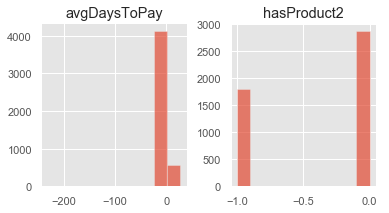

In [21]:
matplotlib.style.use('ggplot')
skewLeftDf = dataFrame.loc[:,skewLeftColumns.index]
skewLeftDf.loc[:,skewLeftDf.columns] = scaler.fit_transform(skewLeftDf.loc[:,skewLeftDf.columns])
skewLeftDf.hist(alpha=0.7, figsize=(6, 3))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001317B1455C0>,
      dtype=object)

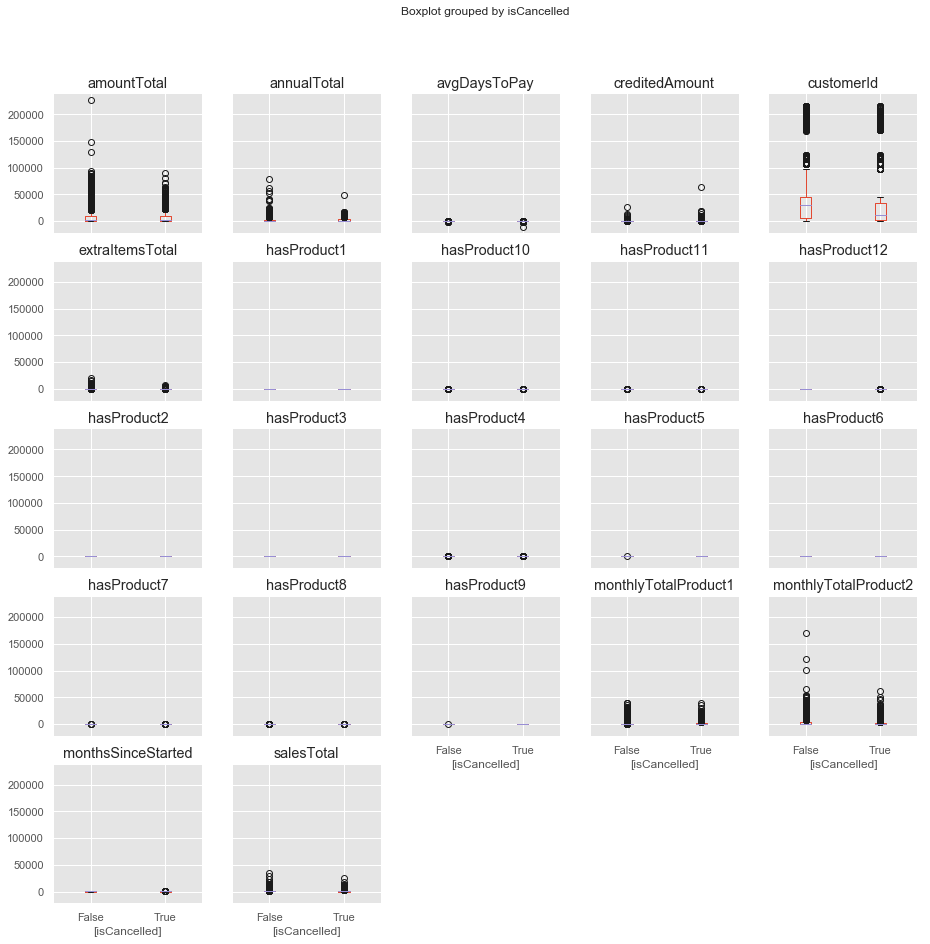

In [22]:
# log tranform all right skewed cols:
#logDfRightTest = np.log2(1+skewRightDf['amountTotal'])
#skewRightDf.hist(alpha=0.7, figsize=(6, 3))
dataFrame.boxplot(by= isCancelledKey,figsize= (15,15))   

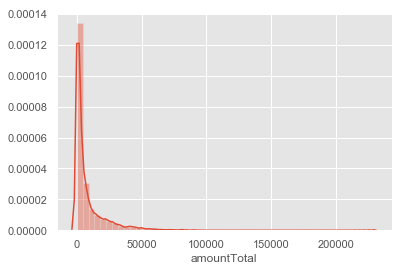

In [23]:
sns.distplot(dataFrame['amountTotal'],kde=True)

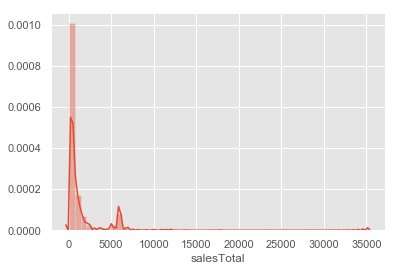

In [24]:
sns.distplot(dataFrame['salesTotal'],kde=True)

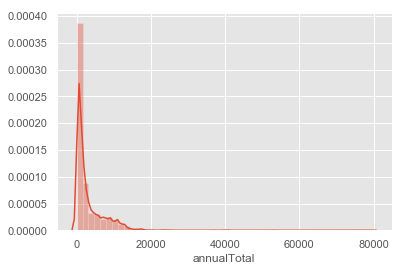

In [25]:
sns.distplot(dataFrame['annualTotal'],kde=True)

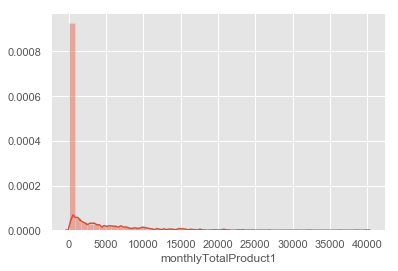

In [26]:
sns.distplot(dataFrame['monthlyTotalProduct1'],kde=True)

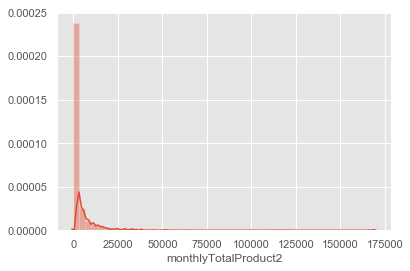

In [27]:
sns.distplot(dataFrame['monthlyTotalProduct2'],kde=True)

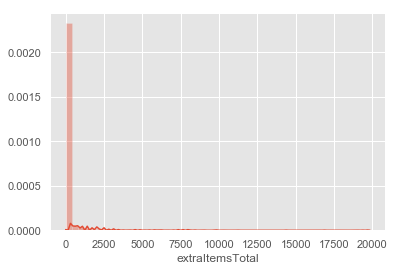

In [28]:
sns.distplot(dataFrame['extraItemsTotal'],kde=True)

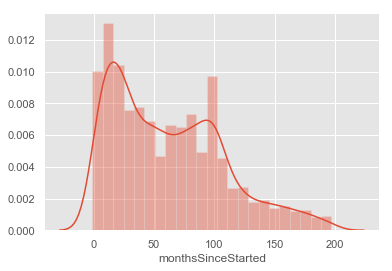

In [29]:
sns.distplot(dataFrame['monthsSinceStarted'],kde=True)

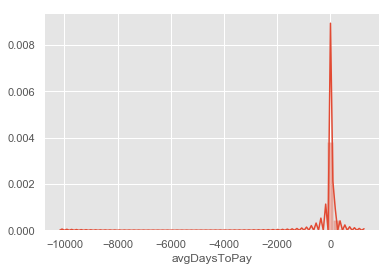

In [30]:
sns.distplot(dataFrame['avgDaysToPay'],kde=True)

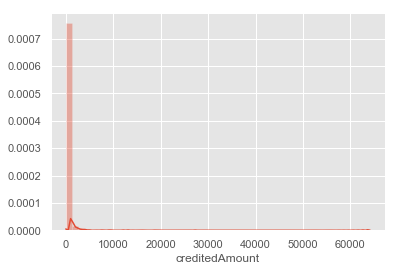

In [31]:
sns.distplot(dataFrame['creditedAmount'],kde=True)

# Distrubution of catagorical variables

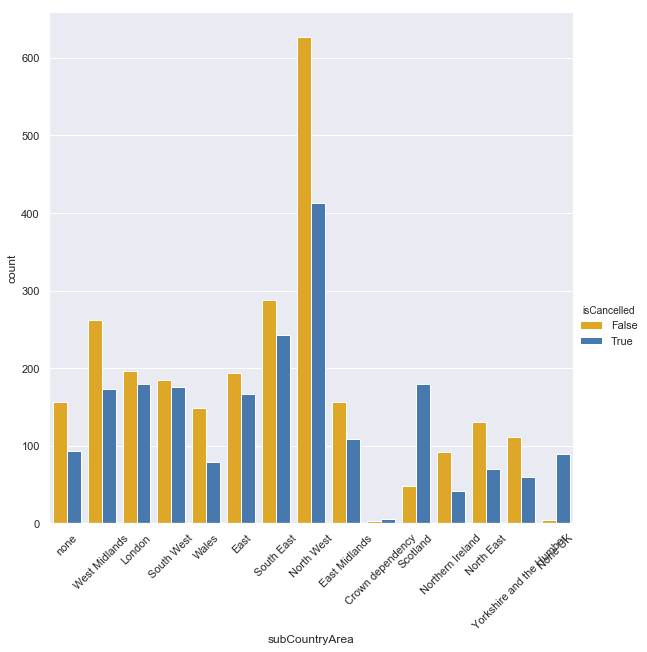

In [34]:
fig = sns.catplot(x=subCountryKey,height=8, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalSubCountryArea.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

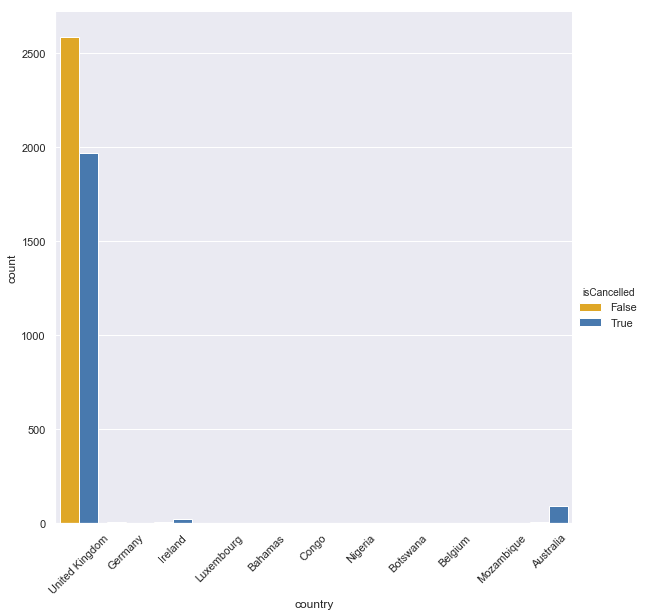

In [74]:
fig = sns.catplot(x=countryKey,height=8, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalCountry.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

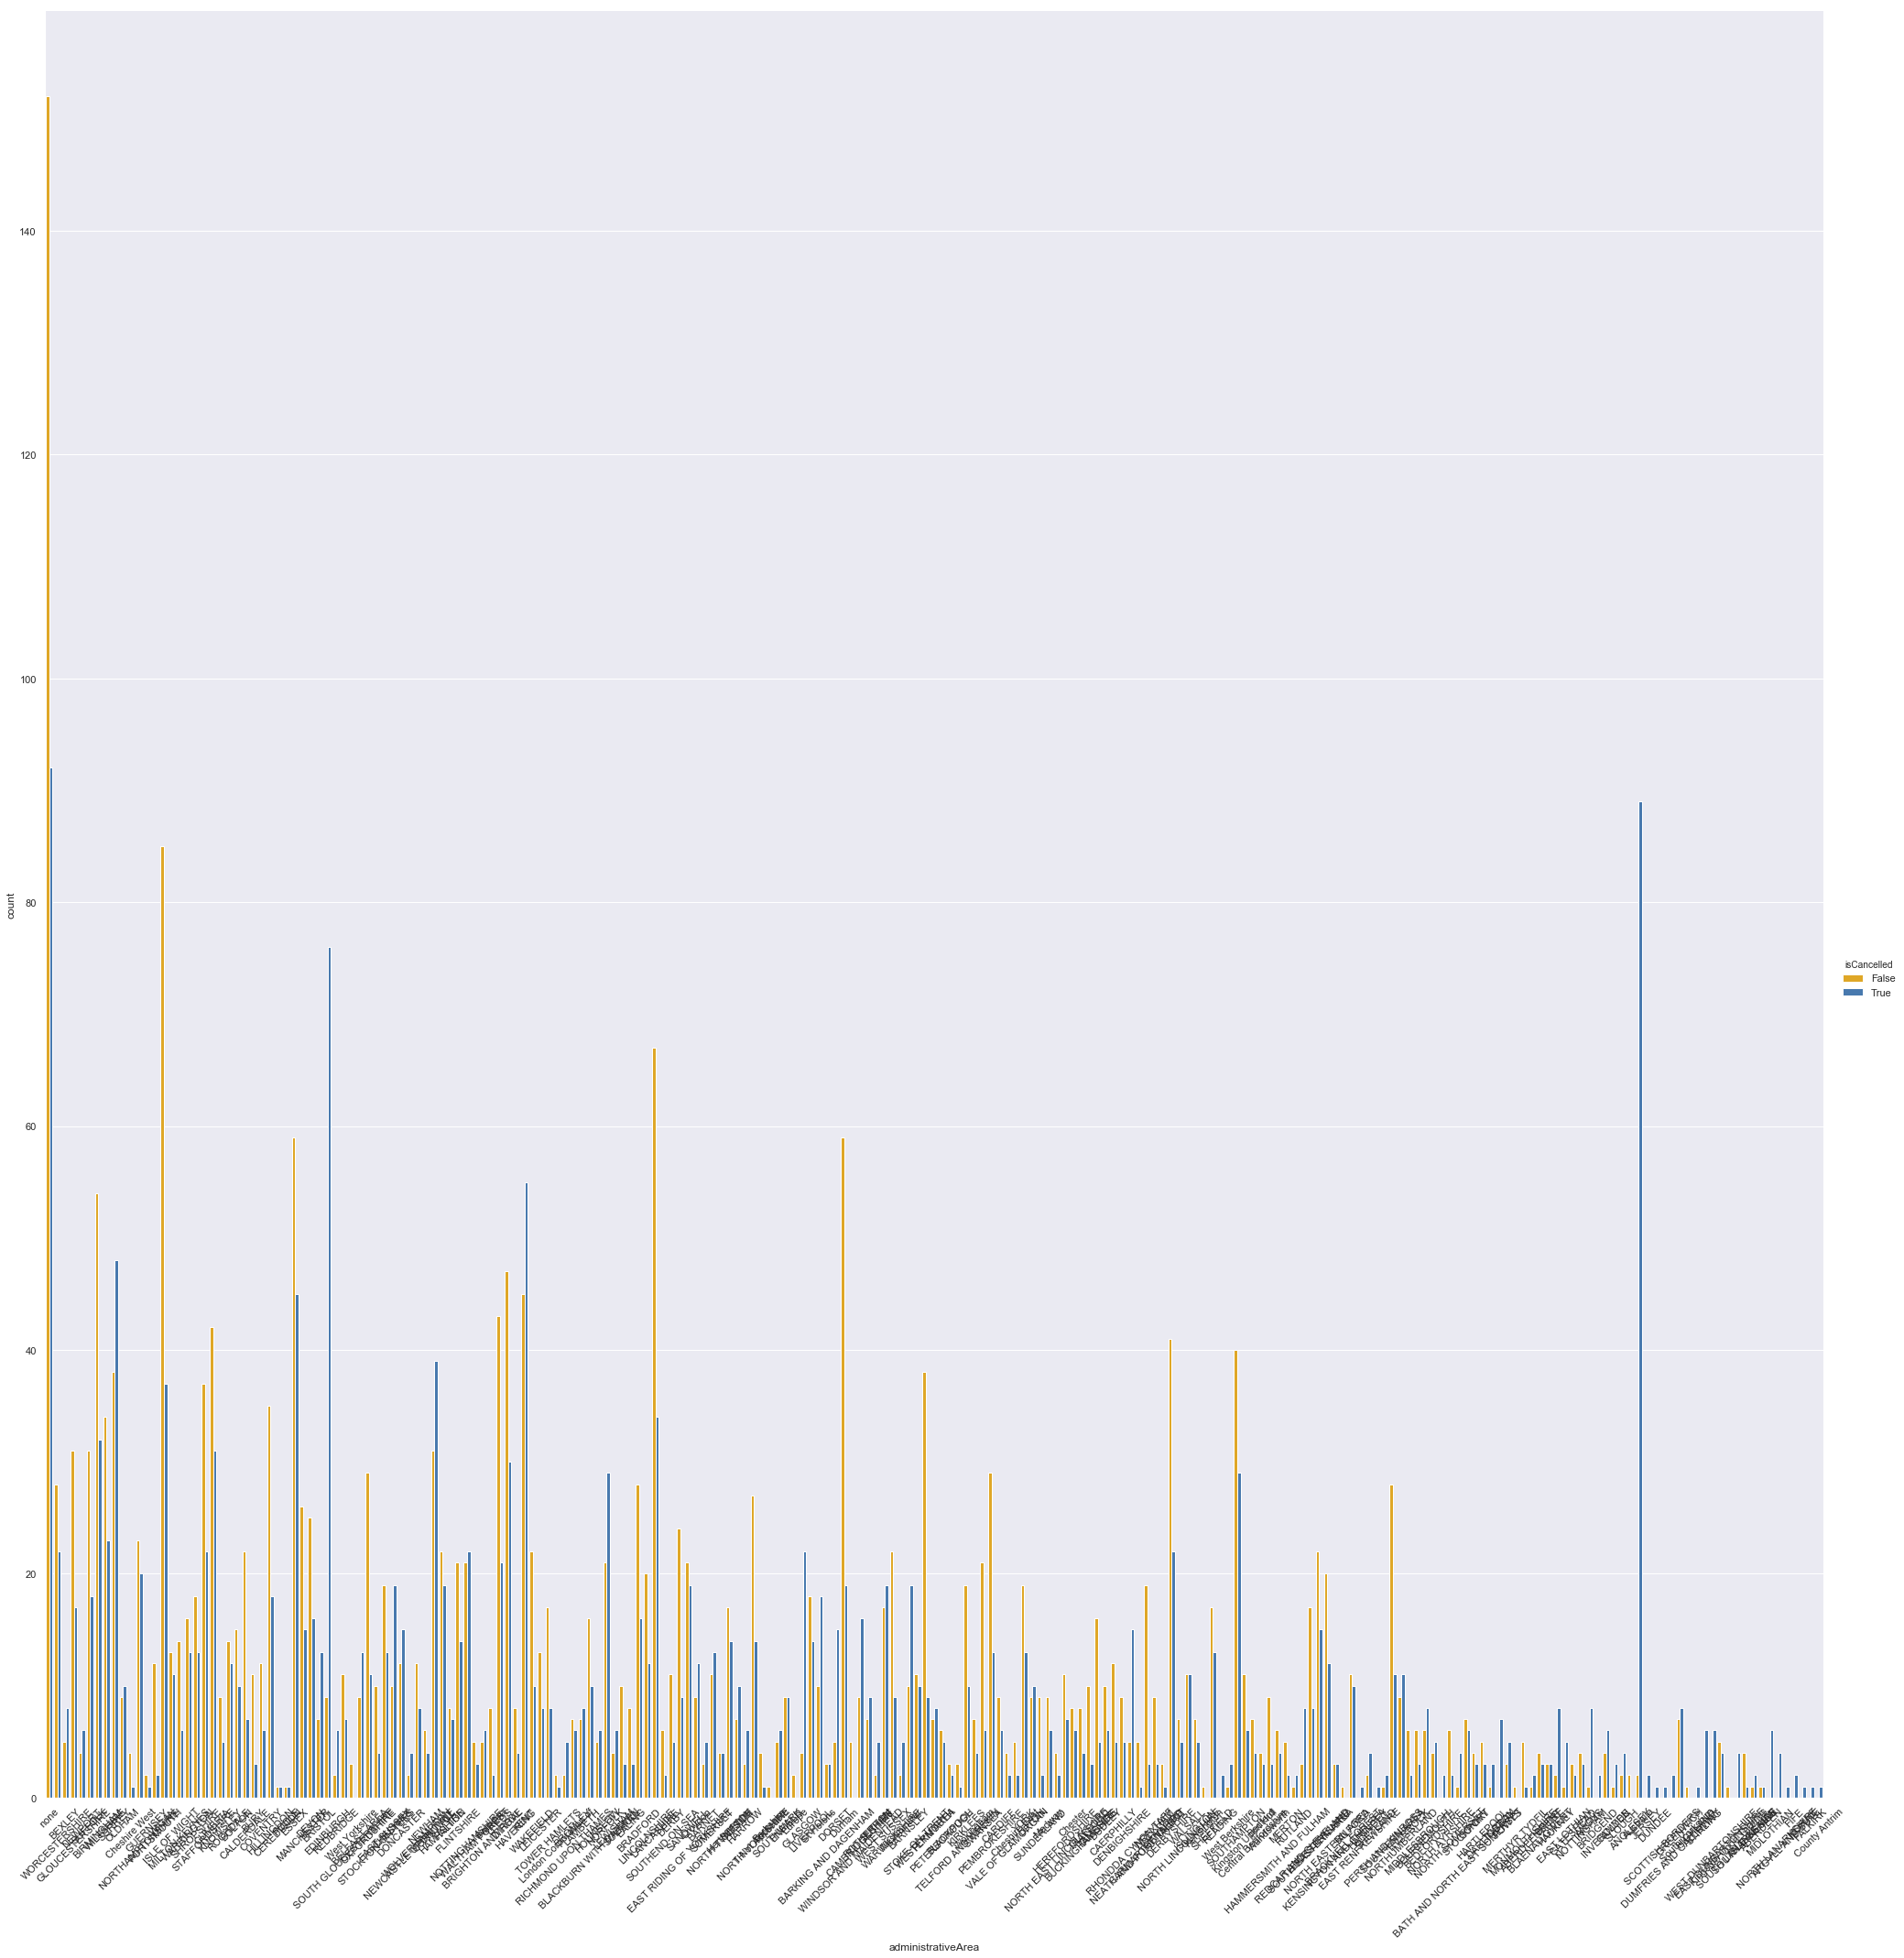

In [75]:
fig = sns.catplot(x=adminAreaKey,height=28, hue=isCancelledKey, kind="count", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('catagoricalAdminArea.eps', format='eps')

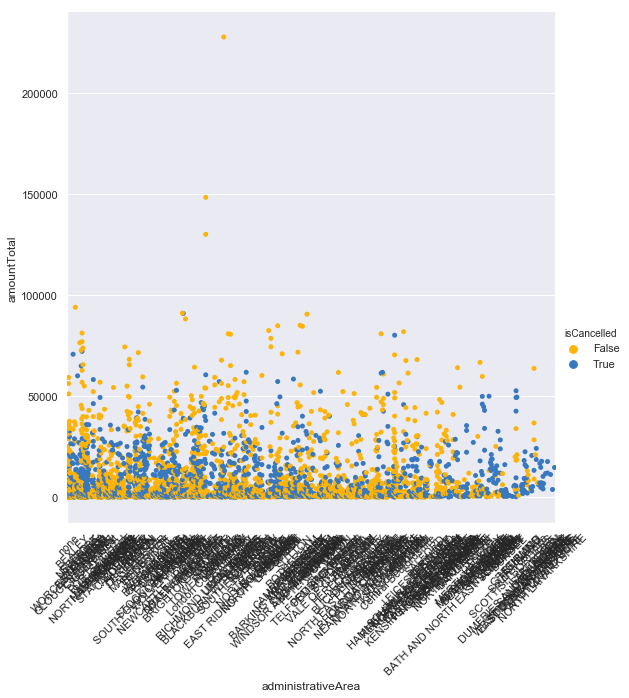

In [76]:
fig = sns.catplot(x=adminAreaKey, y='amountTotal', height=8, hue=isCancelledKey, kind="swarm", data=dataFrame);
plt.xticks(rotation=45)
fig = fig.fig
fig.savefig('adminAreaOverAmountTotal.eps', format='eps')
#[adminAreaKey, subCountryKey,countryKey]

# References
Fine tuning a classifier in scikit-learn
- https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
- conditional-probability coding (CP-coding) - https://medium.com/airbnb-engineering/designing-machine-learning-models-7d0048249e69
- feature scaleing options http://benalexkeen.com/feature-scaling-with-scikit-learn/